In [33]:
import pandas as pd
import numpy as np
#import bar_chart_race as bcr
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [2]:
csv_name = 'Nogomet - Podsused - sezona 2022-2023.csv'
data = pd.read_csv(csv_name, skiprows = 1) 

In [28]:
data['Opis'] = 'Sezona 2022/2023'
data.head()
igraci = ['Ceki', 'Zvonac', 'Martin', 'Jaga','Nikoletić', 'Kos', 'Duje', 'Joza','Dinko', 'Zdela', 'Dragan', 'Tin', 'Vido',
       'Jura', 'Toni', 'Rukavina', 'Cigi','Brla', 'Ciba', 'Bojan', 'Mate']

In [4]:
# Setting date as index
data['Termini'] = pd.to_datetime(data['Termini'])
data.set_index('Termini', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2022-09-13 to 2023-08-08
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ceki       25 non-null     object
 1   Zvonac     25 non-null     object
 2   Martin     25 non-null     object
 3   Jaga       25 non-null     object
 4   Nikoletić  25 non-null     object
 5   Kos        25 non-null     object
 6   Duje       25 non-null     object
 7   Joza       25 non-null     object
 8   Dinko      25 non-null     object
 9   Zdela      25 non-null     object
 10  Dragan     25 non-null     object
 11  Tin        25 non-null     object
 12  Vido       25 non-null     object
 13  Jura       25 non-null     object
 14  Toni       25 non-null     object
 15  Rukavina   25 non-null     object
 16  Cigi       25 non-null     object
 17  Brla       25 non-null     object
 18  Ciba       25 non-null     object
 19  Bojan      25 non-null     object
 20  Mate       25 

In [5]:
# odigrani susreti
# counts = counts.rename(columns=lambda col: col+'_count')
columns = ['Ceki', 'Zvonac', 'Martin', 'Jaga', 'Nikoletić', 'Kos', 'Duje', 'Joza','Dinko', 'Zdela', 'Dragan', 'Tin', 'Vido', 'Jura', 'Toni', 'Rukavina','Cigi', 'Brla', 'Ciba', 'Bojan', 'Mate']
#columns = ['Ceki', 'Zvonac']
pobjede = []
porazi = []
ner = []
pobjede_perc = []
odigrani = []

for column in columns:
    pobjede.append('pobjede_'+column)
    porazi.append('porazi_'+column)
    pobjede_perc.append('%_pobjeda_'+column)
    odigrani.append('odigrani_'+column)
    ner.append('ner_'+column)
    
    data['odigrani_'+column] = data[data[column]!='-'].groupby('Opis')[column].cumcount()+1
    data['igre_'+column] = data.groupby(column)[column].cumcount()+1
    data['pobjede_'+column] = data['igre_'+column][data[column]=='Win']
    data['porazi_'+column] = data['igre_'+column][data[column]=='Lose']
    data['ner_'+column] = data['igre_'+column][data[column]=='Draw']
    data['odigrani_'+column].fillna(method='ffill', inplace=True) 
    data['pobjede_'+column].fillna(method='ffill', inplace=True)
    data['porazi_'+column].fillna(method='ffill', inplace=True)
    data['ner_'+column].fillna(method='ffill', inplace=True)
    data['odigrani_'+column].fillna(0, inplace=True) 
    data['pobjede_'+column].fillna(0, inplace=True)
    data['porazi_'+column].fillna(0, inplace=True)
    data['ner_'+column].fillna(0, inplace=True)
   

    #kalkulacija
    data['%_pobjeda_'+column] = data['pobjede_'+column] / data['odigrani_'+column]
    
    data['Score_%_pobjeda_'+column] = 1
    data['Score_#_pobjeda_'+column] = 1
    data['Score_#_poraza_'+column]= 1
    data['Score_#_odigrani_'+column]= 1
    data['Score_konacna_lista_'+column]= 1
    
#data['total_played'] = data[pobjede + porazi + ner].sum(axis=1) 
data.dropna(subset = columns, inplace=True)
data['termin_ne_igran'] = data[columns].eq(data.iloc[:, 0], axis=0).all(axis=1)
data.drop(data[data['termin_ne_igran'] == True].index, inplace=True)
data.drop(['termin_ne_igran'],inplace=True, axis=1)


pobjede = data[pobjede]
pobjede = pobjede.join(pobjede.rank(ascending=True, method='min', axis=1), rsuffix='_rank')
different_cols = pobjede.columns.difference(data.columns)
data = pd.merge(data, pobjede[different_cols], how='inner', left_index=True,right_index=True)

porazi = data[porazi]
porazi = porazi.join(porazi.rank(ascending=True, method='dense', axis=1), rsuffix='_rank')
different_cols = porazi.columns.difference(data.columns)
data = pd.merge(data, porazi[different_cols], how='inner', left_index=True,right_index=True)

pobjede_perc = data[pobjede_perc]
pobjede_perc = pobjede_perc.join(pobjede_perc.rank(ascending=True, method='min', axis=1), rsuffix='_rank')
different_cols = pobjede_perc.columns.difference(data.columns)
data = pd.merge(data, pobjede_perc[different_cols], how='inner', left_index=True,right_index=True)

odigrani = data[odigrani]
odigrani = odigrani.join(odigrani.rank(ascending=True, method='min', axis=1), rsuffix='_rank')
different_cols = odigrani.columns.difference(data.columns)
data = pd.merge(data, odigrani[different_cols], how='inner', left_index=True,right_index=True)

scores = []
for column in columns:
    scores.append('Score_'+column)
    data['Score_'+column] = data['pobjede_'+column+'_rank'] + data['%_pobjeda_'+column+'_rank'] + data['odigrani_'+column+'_rank'] - data['porazi_'+column+'_rank']
    data['Score_'+column].fillna(0, inplace=True)

pobjede_rank = []  
pobjede_perc_rank = []  
porazi_rank = []  
odigrani_rank = []  
odigrani_count = []
for column in columns:
    pobjede_rank.append('pobjede_'+column+'_rank')
    pobjede_perc_rank.append('%_pobjeda_'+column+'_rank')
    porazi_rank.append('porazi_'+column+'_rank')
    odigrani_rank.append('odigrani_'+column+'_rank')
    odigrani_count.append('odigrani_'+column)
    

In [ ]:
# https://www.dexplo.org/bar_chart_race/tutorial/
data_bar_race = data[scores].copy()
data_bar_race.columns = data_bar_race.columns.str.lstrip("Score_")

bcr.bar_chart_race(df=data_bar_race, filename=None, orientation='h',period_length=1500,
    figsize=(5, 3),  cmap='antique', steps_per_period=100, dpi=150, title='Statistika po tjednima kumulativno'
)



# Status after last match

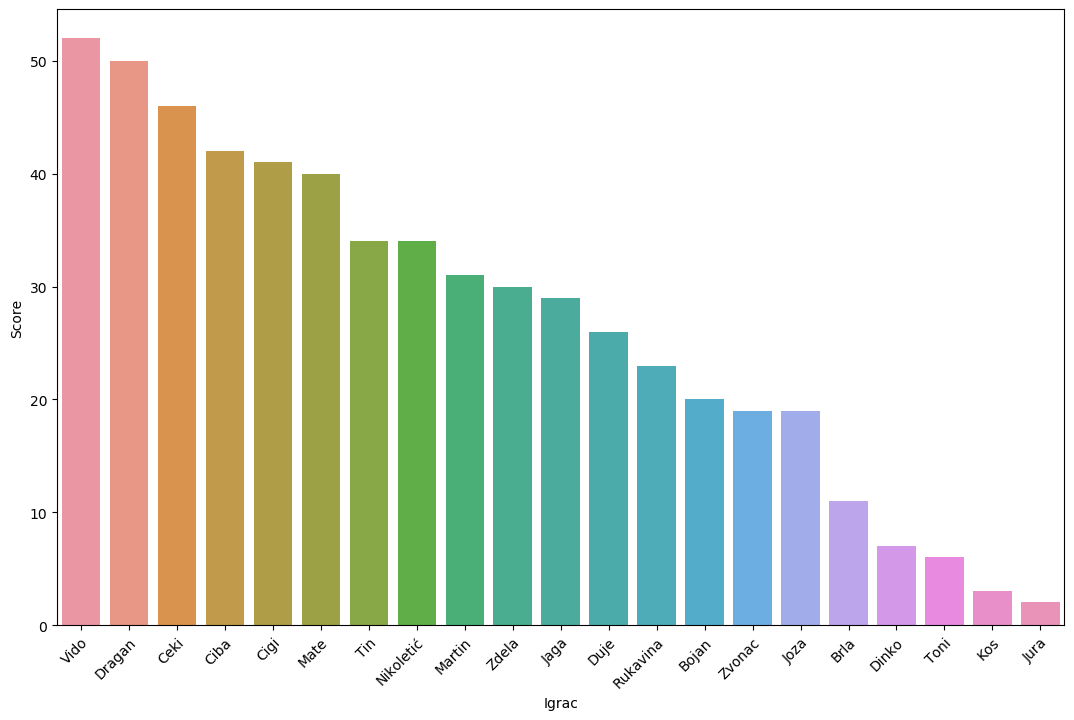

In [21]:
last_termin = data[scores].loc[data[scores].index[-1:]].copy()
last_termin = last_termin.reset_index()
un_pivot = last_termin.melt(id_vars= 'Termini', var_name="Igrac", value_name="Score")
un_pivot.sort_values(by=['Score'], inplace=True, ascending=False)
un_pivot['Igrac'] = un_pivot['Igrac'].str.replace('Score_','')
plt.rcParams["figure.figsize"] = [13, 8]
g = sns.barplot( data = un_pivot, x = 'Igrac', y = 'Score')
#plt.xticks(rotation=70)
plt.setp(g.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [9]:
last_pobjede = data[pobjede_rank].loc[data[pobjede_rank].index[-1:]].copy()
last_pobjede = last_pobjede.reset_index()
last_pobjede = last_pobjede.melt(id_vars= 'Termini', var_name="Igrac", value_name="Pobjede")
last_pobjede['Igrac'] = last_pobjede['Igrac'].str.replace('pobjede_','')
last_pobjede['Igrac'] = last_pobjede['Igrac'].str.replace('_rank','')

last_pobjede_perc = data[pobjede_perc_rank].loc[data[pobjede_perc_rank].index[-1:]].copy()
last_pobjede_perc = last_pobjede_perc.reset_index()
last_pobjede_perc = last_pobjede_perc.melt(id_vars= 'Termini', var_name="Igrac", value_name="Pobjede_Percent")
last_pobjede_perc['Igrac'] = last_pobjede_perc['Igrac'].str.replace('%_pobjeda_','')
last_pobjede_perc['Igrac'] = last_pobjede_perc['Igrac'].str.replace('_rank','')

last_porazi = data[porazi_rank].loc[data[porazi_rank].index[-1:]].copy()
last_porazi = last_porazi.reset_index()
last_porazi = last_porazi.melt(id_vars= 'Termini', var_name="Igrac", value_name="Porazi")
last_porazi['Igrac'] = last_porazi['Igrac'].str.replace('porazi_','')
last_porazi['Igrac'] = last_porazi['Igrac'].str.replace('_rank','')

last_odigrani = data[odigrani_rank].loc[data[odigrani_rank].index[-1:]].copy()
last_odigrani = last_odigrani.reset_index()
last_odigrani = last_odigrani.melt(id_vars= 'Termini', var_name="Igrac", value_name="Odigrani")
last_odigrani['Igrac'] = last_odigrani['Igrac'].str.replace('odigrani_','')
last_odigrani['Igrac'] = last_odigrani['Igrac'].str.replace('_rank','')

final = pd.merge(un_pivot, last_pobjede, on=['Termini','Igrac'],how='outer') 
final = pd.merge(final, last_pobjede_perc, on=['Termini','Igrac'],how='outer') 
final = pd.merge(final, last_porazi, on=['Termini','Igrac'],how='outer') 
final = pd.merge(final, last_odigrani, on=['Termini','Igrac'],how='outer') 

final['Porazi'] = 0-final['Porazi']


In [10]:
x = ['Pobjede','Pobjede_Percent','Odigrani', 'Porazi', "Score"]
columns2 =  ['Ceki', 'Zvonac']

i = 0
j = 0
fig = make_subplots(rows=3, cols=7)
for column in columns:
    j = columns.index(column)%7+1
    i = columns.index(column)%3+1
    fig.add_trace(go.Waterfall(
    name = column, 
    orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "total"],
    x = [column + ' ' + s for s in x],
    textposition = "inside",
    text = final[final['Igrac']==column][x].values.tolist()[0],
    y = final[final['Igrac']==column][x].values.tolist()[0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}} )
   ,row=i, col=j)

fig.update_layout(height=1000, width=1500,
                  title = "Doprinos stavke ukupnom rezultatu",
            showlegend = True
)

fig.write_image('doprinos_po_igracu.png')

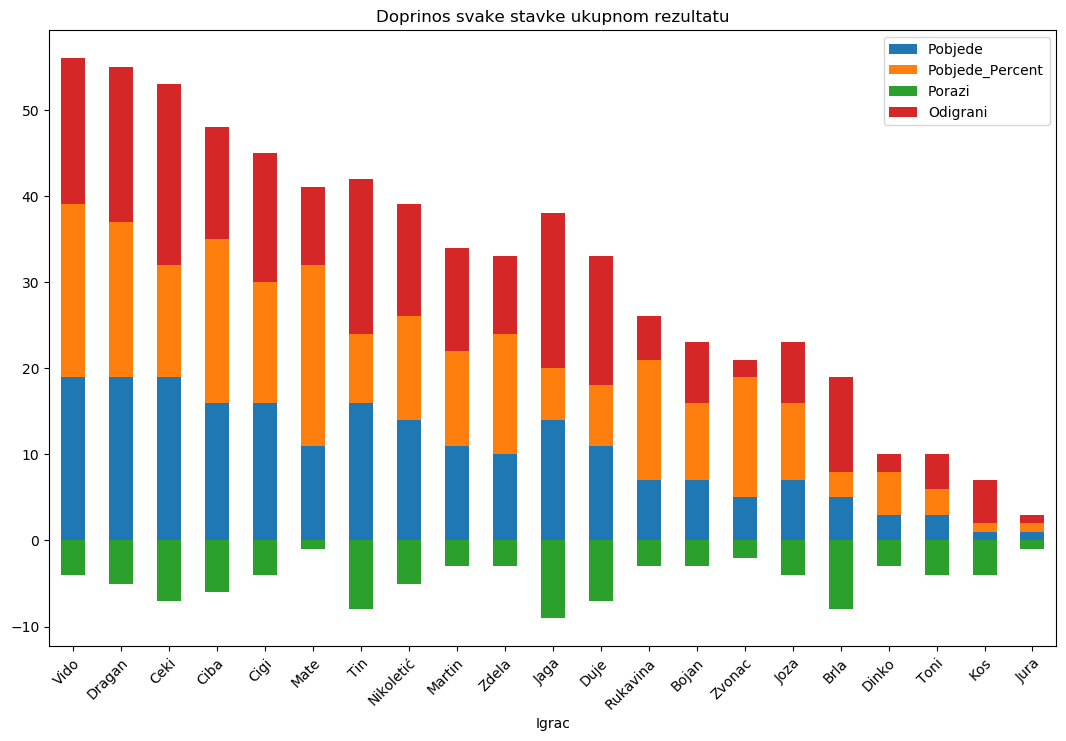

In [11]:
bar_cols = ['Igrac', 'Pobjede','Pobjede_Percent','Porazi', 'Odigrani']
x = final[bar_cols].plot(x='Igrac', kind='bar', stacked=True,
        title='Doprinos svake stavke ukupnom rezultatu')

plt.setp(x.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [ ]:
final[final['Igrac']=='Ceki']

In [ ]:
x = ['Pobjede','Pobjede_Percent','Odigrani', 'Porazi', "Score"]
final[final['Igrac']=='Ceki'][x].values.tolist()[0]

In [13]:


x = ['Pobjede','Pobjede_Percent','Odigrani', 'Porazi', 'Score']
fig = go.Figure(go.Waterfall(
    name = "Doprinos", orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "total"],
    x = [column + '_' + s for s in x],
    textposition = "outside",
  # text = final[final['Igrac']=='Ceki'][x],
    y = final[final['Igrac']=='Ceki'][x].values.tolist()[0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Doprinos stavke ukupnom rezultatu",
        showlegend = True
)

fig.show()

In [14]:


#columns2 =  ['Ceki', 'Zvonac']

i = 0
j = 0
fig = make_subplots(rows=3, cols=7)
for column in columns:
    j = columns.index(column)%7+1
    i = columns.index(column)%3+1
    fig.add_trace(go.Waterfall(
    name = column, 
    orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "total"],
    x = [column + ' ' + s for s in x],
    textposition = "inside",
    text = final[final['Igrac']==column][x].values.tolist()[0],
    y = final[final['Igrac']==column][x].values.tolist()[0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}} )
   ,row=i, col=j)

fig.update_layout(height=1000, width=1500,
                  title = "Doprinos stavke ukupnom rezultatu",
            showlegend = True
)

In [ ]:
odigrani_count

In [15]:
last_odigrani_count = data[odigrani_count].loc[data[odigrani_count].index[-1:]].copy()
last_odigrani_count = last_odigrani_count.reset_index()
last_odigrani_count = last_odigrani_count.melt(id_vars= 'Termini', var_name="Igrac", value_name="Odigrani")
last_odigrani_count['Igrac'] = last_odigrani_count['Igrac'].str.replace('odigrani_','')
last_odigrani_count.sort_values(by='Odigrani', ascending=False)

Termini      Igrac  Odigrani
0  2023-02-28       Ceki      19.0
3  2023-02-28       Jaga      17.0
11 2023-02-28        Tin      17.0
10 2023-02-28     Dragan      17.0
12 2023-02-28       Vido      15.0
16 2023-02-28       Cigi      14.0
6  2023-02-28       Duje      14.0
18 2023-02-28       Ciba      13.0
4  2023-02-28  Nikoletić      13.0
2  2023-02-28     Martin      11.0
17 2023-02-28       Brla      10.0
9  2023-02-28      Zdela       8.0
20 2023-02-28       Mate       8.0
7  2023-02-28       Joza       7.0
19 2023-02-28      Bojan       7.0
5  2023-02-28        Kos       6.0
15 2023-02-28   Rukavina       6.0
14 2023-02-28       Toni       5.0
1  2023-02-28     Zvonac       4.0
8  2023-02-28      Dinko       4.0
13 2023-02-28       Jura       3.0

In [ ]:
#res = pobjede + porazi
#data[pobjede + porazi]



In [ ]:

pobjede_rank = ['pobjede_Ceki_rank', 'pobjede_Zvonac_rank',
       'pobjede_Martin_rank', 'pobjede_Jaga_rank', 'pobjede_Nikoletić_rank',
       'pobjede_Kos_rank', 'pobjede_Duje_rank', 'pobjede_Joza_rank',
       'pobjede_Dinko_rank', 'pobjede_Zdela_rank', 'pobjede_Dragan_rank',
       'pobjede_Tin_rank', 'pobjede_Vido_rank', 'pobjede_Jura_rank',
       'pobjede_Toni_rank', 'pobjede_Rukavina_rank', 'pobjede_Cigi_rank',
       'pobjede_Brla_rank', 'pobjede_Ciba_rank', 'pobjede_Bojan_rank',
       'pobjede_Mate_rank']
ranked[pobjede_rank].tail(1)

In [ ]:
data['pobjede_Dragan_rank'].tail(1)

In [ ]:
pobjede.columns

In [ ]:
pobjede.head()


In [ ]:
data = pd.merge(data, pobjede, how='inner', left_index=True,right_index=True)
data.columns

In [ ]:
#data.loc[data.index[-1:]][scores]

In [ ]:
plt.rcParams["figure.figsize"] = [13, 8]
g = sns.barplot( data = data.loc[data.index[-1:]][scores])
#plt.xticks(rotation=70)
plt.setp(g.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [16]:
svi_termini = data[scores].copy()
svi_termini = svi_termini.reset_index()
svi_termini_un_pivot = svi_termini.melt(id_vars= 'Termini', var_name="Igrac", value_name="Score")
svi_termini_un_pivot.sort_values(by=['Score'], inplace=True, ascending=False)
svi_termini_un_pivot['Igrac'] = svi_termini_un_pivot['Igrac'].str.replace('Score_','')
svi_termini_un_pivot

Termini   Igrac  Score
5   2022-10-25    Ceki   59.0
4   2022-10-18    Ceki   56.0
7   2022-11-15    Ceki   56.0
228 2023-02-14  Dragan   55.0
6   2022-11-08    Ceki   54.0
..         ...     ...    ...
404 2022-10-25   Bojan    0.0
405 2022-11-08   Bojan    0.0
406 2022-11-15   Bojan    0.0
407 2022-11-22   Bojan    0.0
189 2022-09-13   Zdela    0.0

[441 rows x 3 columns]

In [ ]:
#sns.violinplot(x = 'Igrac', y = 'Score', data = svi_termini_un_pivot)

In [ ]:
#sns.lineplot(x = 'Termini', y = 'Score', data = svi_termini_un_pivot, hue='Igrac')

ConversionError: Failed to convert value(s) to axis units: ''

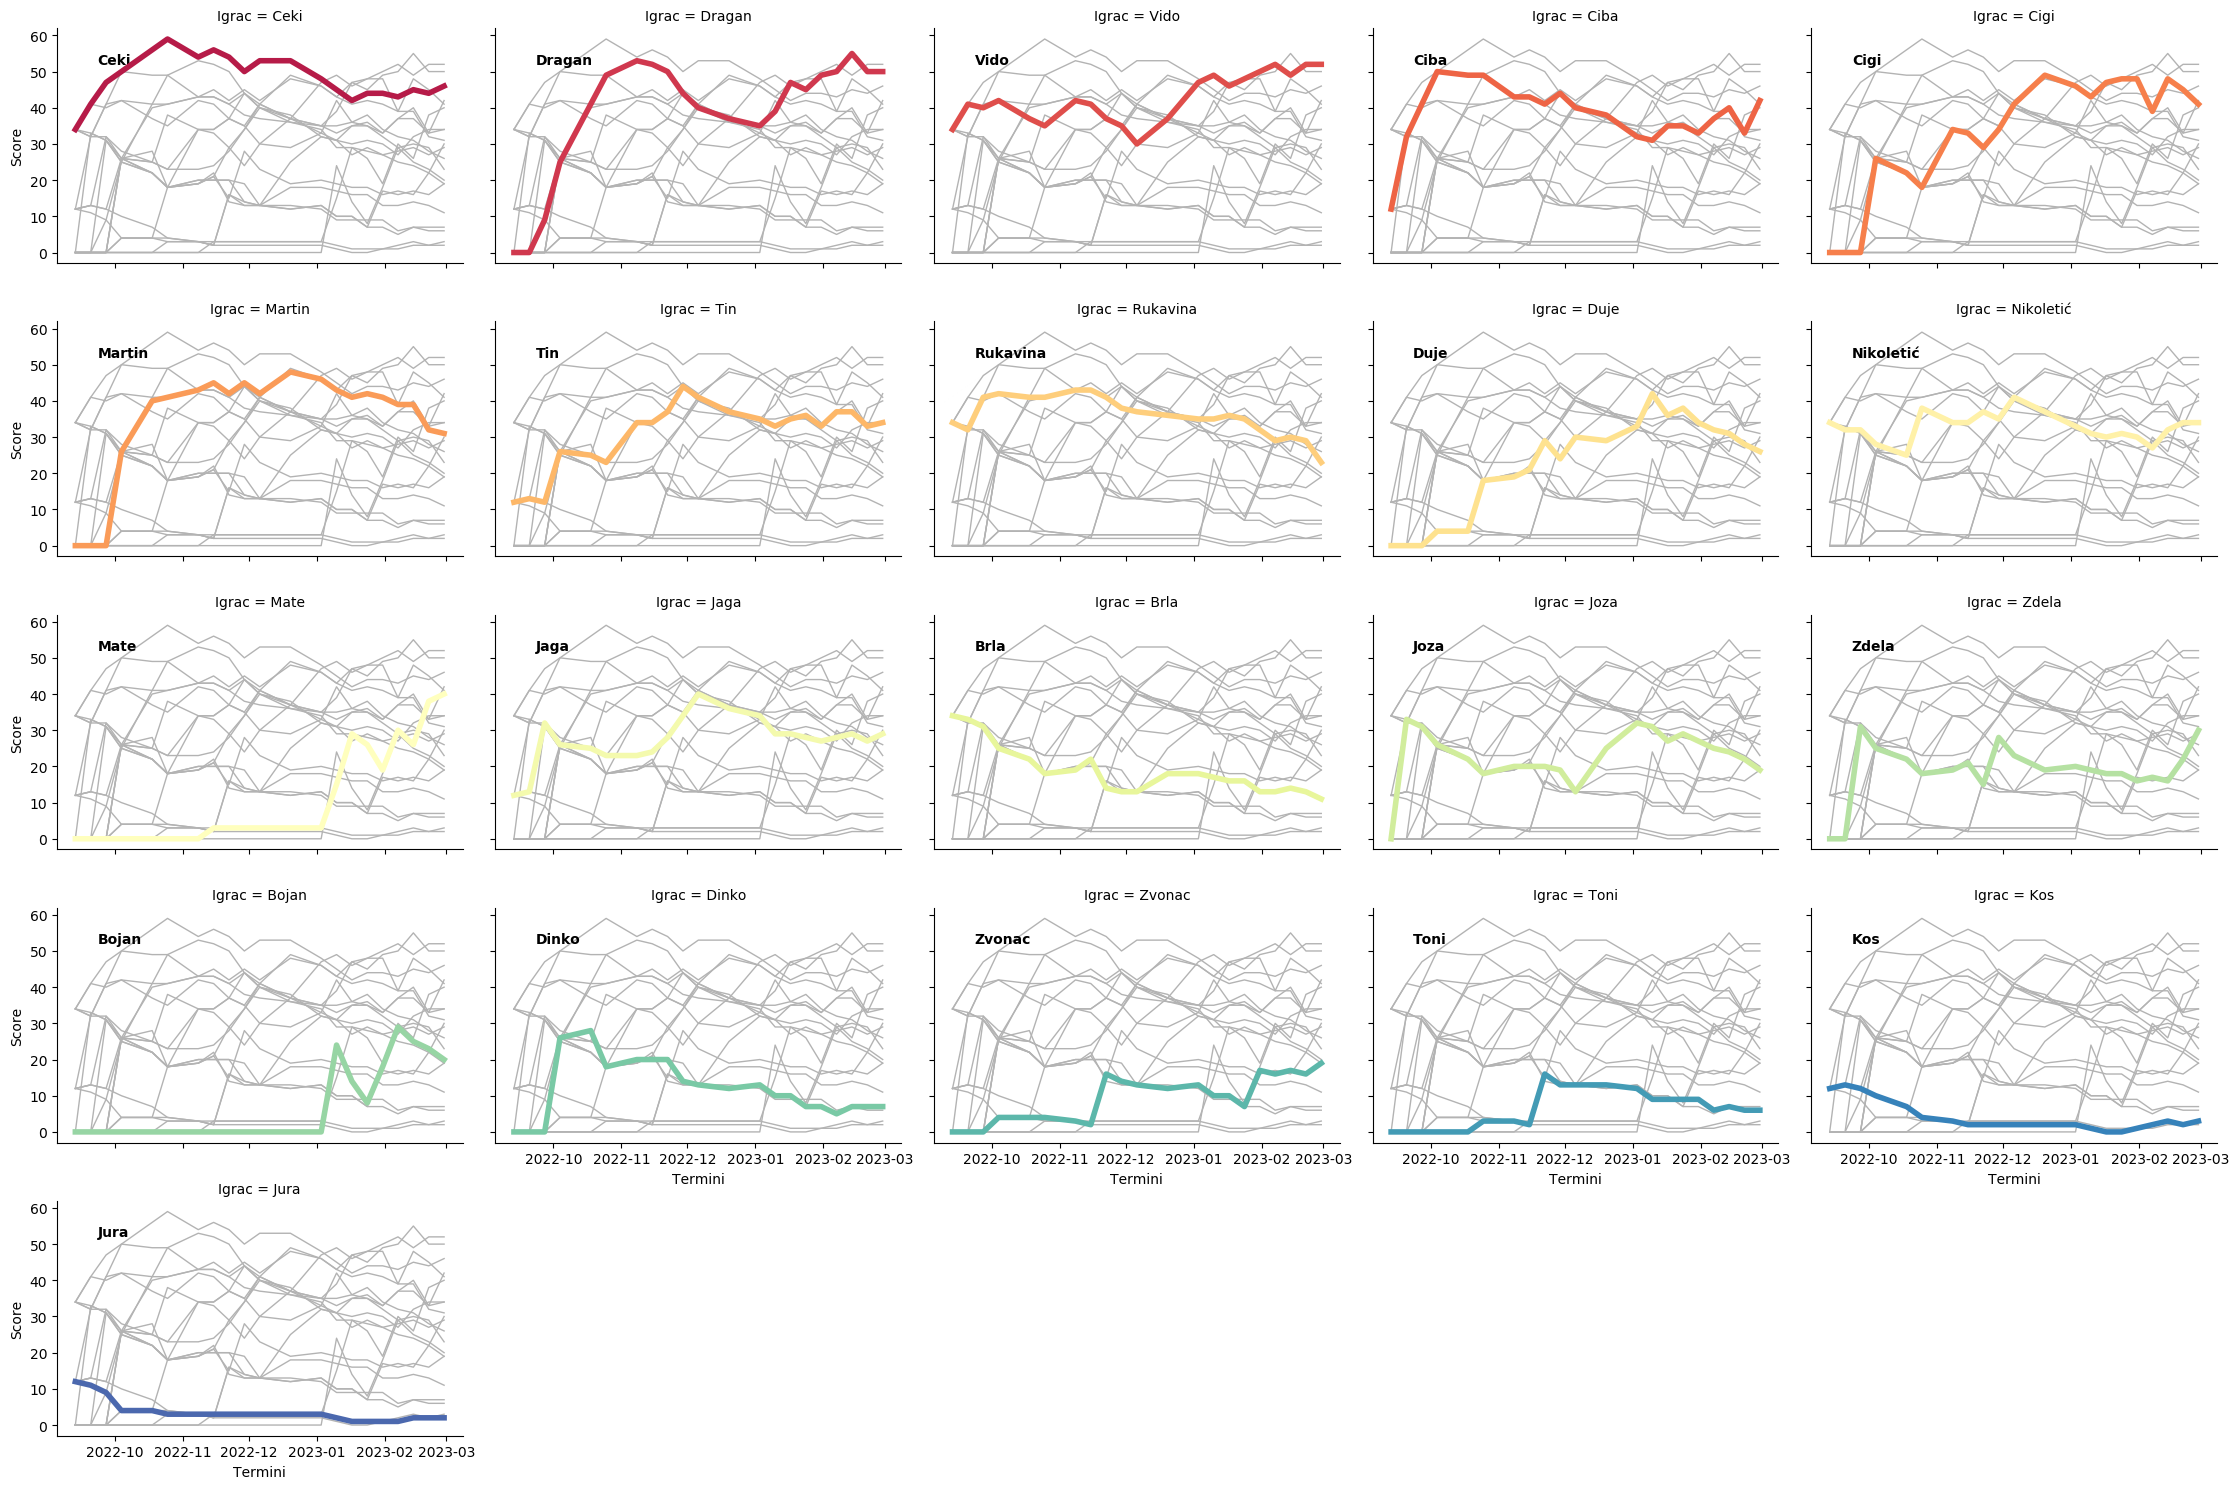

In [18]:
g = sns.relplot(data = svi_termini_un_pivot, x = "Termini", y = "Score",
                col = "Igrac", hue = "Igrac",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = svi_termini_un_pivot, x = "Termini", y = "Score", units="Igrac",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

ax.set_xticks('')
g.set_titles("")
g.set_axis_labels("", "Score")
g.tight_layout()


In [31]:
svi_rezultati = data[igraci].copy()
svi_rezultati = svi_rezultati.reset_index()
svi_rezultati_un_pivot = svi_rezultati.melt(id_vars= 'Termini', var_name="Igrac", value_name="Rezultat")
#svi_rezultati_un_pivot.sort_values(by=['Rezultat'], inplace=True, ascending=False)
#svi_rezultati_un_pivot['Igrac'] = svi_rezultati_un_pivot['Igrac'].str.replace('Score_','')
svi_rezultati_un_pivot


Termini Igrac Rezultat
0   2022-09-13  Ceki      Win
1   2022-09-20  Ceki      Win
2   2022-09-27  Ceki      Win
3   2022-10-04  Ceki     Lose
4   2022-10-18  Ceki      Win
..         ...   ...      ...
436 2023-01-31  Mate        -
437 2023-02-07  Mate      Win
438 2023-02-14  Mate     Lose
439 2023-02-21  Mate      Win
440 2023-02-28  Mate      Win

[441 rows x 3 columns]

In [62]:
# https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Plotting/Bubble-Charts.ipynb
    
#svi_rezultati_un_pivot = svi_rezultati_un_pivot.sort_values("Termini", ascending = True)

fig = px.scatter(
    svi_rezultati_un_pivot[svi_rezultati_un_pivot['Rezultat'] != '-'], y='Igrac', x='Termini', color='Rezultat'
    ,symbol='Rezultat',size_max=50,
    color_discrete_sequence=["green", "red", "orange"]
)
fig.update_layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
    )
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')  # for bold add , tickfont_family="Arial Black"
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_layout(height=500, width=1000)
fig.update_coloraxes(colorbar=dict(title='Exports'))
fig.update_traces(marker=dict(sizeref=0.09))
fig.update_yaxes(title="Igrac")
fig.update_xaxes(title='Termin',autorange="reversed")
fig.update_layout(showlegend=True)
fig.update_traces(marker_size=10)
fig.show()

Index(['Termini', 'Score_Ceki', 'Score_Zvonac', 'Score_Martin', 'Score_Jaga',
       'Score_Nikoletić', 'Score_Kos', 'Score_Duje', 'Score_Joza',
       'Score_Dinko', 'Score_Zdela', 'Score_Dragan', 'Score_Tin', 'Score_Vido',
       'Score_Jura', 'Score_Toni', 'Score_Rukavina', 'Score_Cigi',
       'Score_Brla', 'Score_Ciba', 'Score_Bojan', 'Score_Mate'],
      dtype='object')